# SI630: Final Project code for 2_proj_mngmt classification task

***  



# 1. Loading Data

In [1]:
import os
import json, csv
import re

import pandas as pd
import spacy
import sklearn
from glob import glob
from pprint import pprint

#import pickle
from collections import Counter, defaultdict
import numpy as np
#from numpy import argmax
import scipy
import seaborn as sns
import matplotlib
import math
import random
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords 
set(stopwords.words('english'))   
#from numba import jit
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve

from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve


import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
monster_df = pd.read_excel("/Users/yukolopez/Desktop/SI630/Assignments/FinalProject/LR+LDA/monster_com-job_with_label_columns.csv.xlsx", 
                 error_bad_lines=False, sheet_name="monster_com-job_sample", na_filter=False, encoding= 'utf-8')

In [3]:
monster_df = monster_df.replace({'T':True, 'F':False, '':np.nan})

***  

# 2. Pre-processing: Text Cleaning

In [4]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # Remove Emails
    text = re.sub(r"\S*@\S*\s?", "", text)
    
    # Remove new line characters
    text = re.sub(r"\s+", " ", text)
    
    # Remove single quotes
    text = re.sub(r"\'", "", text)
    
    # Convert text to lowercase
    text = text.strip().lower()
    
    # Remove entity abbreviations
    # Add \b in redgex so that it creates word boundary -(e.g) the word, company, remains company.
    text = re.sub(r",?\s*\b(llc|inc|co)\b\.?", "", text)
    
    # Replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

#pprint(text)
    return text


#### If each company name is a string on its own, you can try the following regex: /,?\s*(llc|inc|co)\.?$/i --> 
Optional comma
Optional whitespace
Either one of LLC/Inc/Co (case-insensitive)
Optional period
All the above at the end of the string


In [5]:
labeled_rows = monster_df.loc[~monster_df['1_self_mngmt'].isnull()]
#labeled_rows.count()

In [6]:
X = labeled_rows['job_description']
y = labeled_rows[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']]

***  

### Class Distribution Graph for 215 labeled rows

In [7]:
import seaborn as sns; sns.set()
sns.set_color_codes()

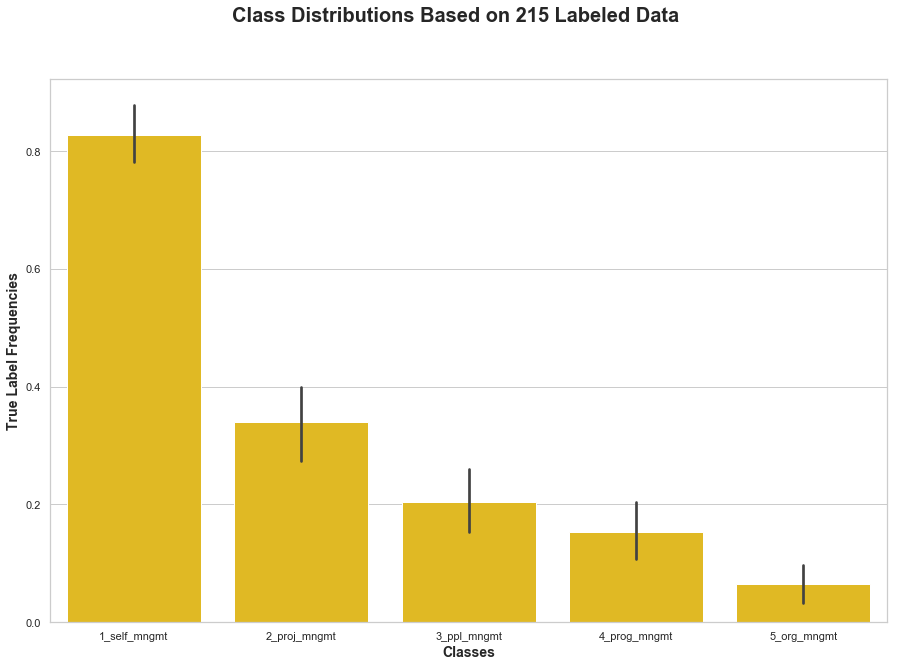

In [8]:
sns.set(style="whitegrid")
colors = ['#ffcb05', '#00274c']

fig, ax = plt.subplots(1, figsize=(15, 10))
sns.barplot(data=y, color='#ffcb05')
plt.suptitle("Class Distributions Based on 215 Labeled Data", fontsize=20, weight = 'bold')
plt.xlabel('Classes', fontsize=14, weight = 'bold')
plt.ylabel('True Label Frequencies', fontsize=14, weight = 'bold')
plt.show()


In [9]:
job_description_word_lengths = np.array(list(map(len, X.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(job_description_word_lengths)))
print("The minimum number of words in a document is: {}.".format(min(job_description_word_lengths)))
print("The maximum number of words in a document is: {}.".format(max(job_description_word_lengths)))

The average number of words in a document is: 313.6232558139535.
The minimum number of words in a document is: 24.
The maximum number of words in a document is: 1133.


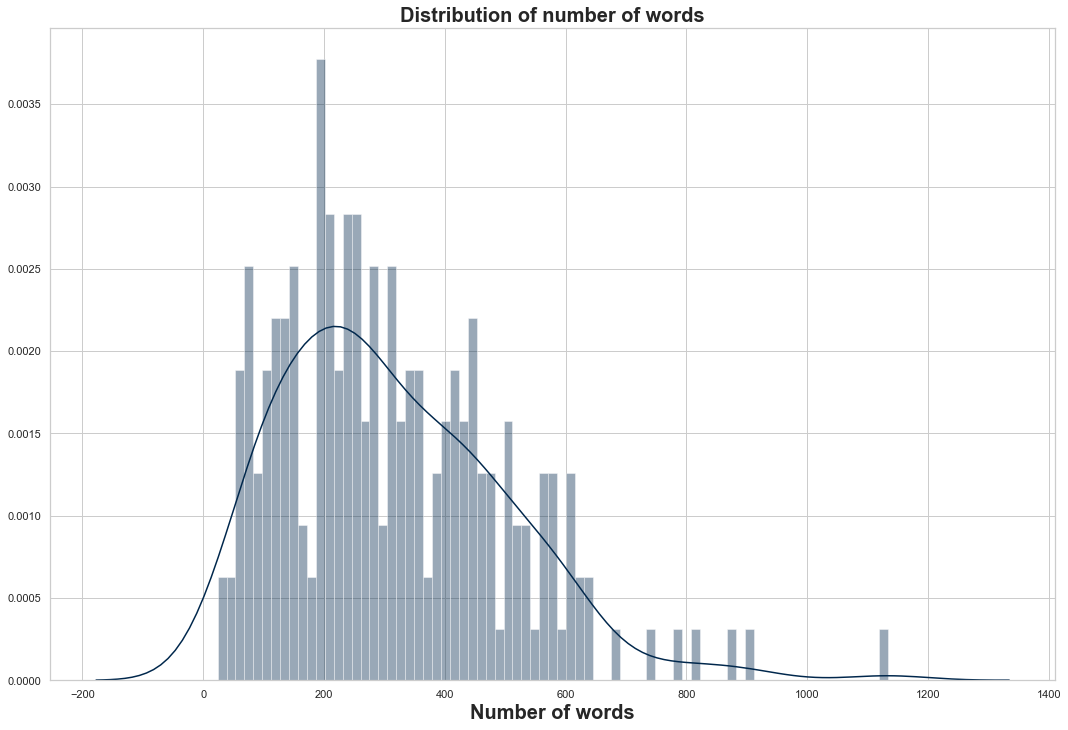

In [10]:
fig, ax = plt.subplots(figsize=(18,12))

ax.set_title("Distribution of number of words", fontsize=20, weight = 'bold')
ax.set_xlabel("Number of words", fontsize=20, weight = 'bold')
sns.distplot(job_description_word_lengths, bins=75, ax=ax, color='#00274c')

In [11]:
print("There are {} documents with over 700 words.".format(sum(job_description_word_lengths > 700)))
print("There are {} documents with less than 700 words.".format(sum(job_description_word_lengths <= 700)))
shorter_documents = job_description_word_lengths[job_description_word_lengths <= 700]

There are 6 documents with over 700 words.
There are 209 documents with less than 700 words.


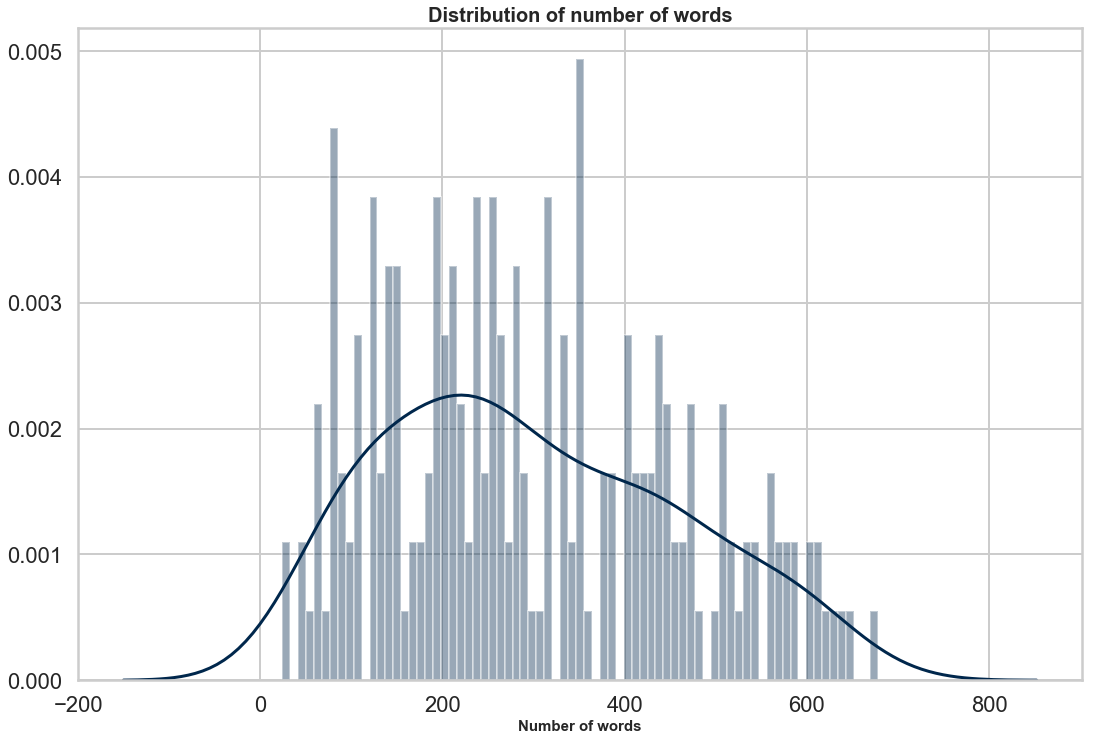

In [12]:
sns.set(style="whitegrid")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(18,12), linewidth=7)

ax.set_title("Distribution of number of words", fontsize=20, weight = 'bold')
ax.set_xlabel("Number of words", fontsize=15, weight = 'bold')
sns.distplot(shorter_documents, bins=75, ax=ax, color='#00274c')

***  

# 3. Building A Basic LR Model

In [13]:
stopwords_lst = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# this vectorizer will skip stop words
#vectorizer = CountVectorizer(stop_words="english", preprocessor=clean_text)
count_vectorizer = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=3, max_df=0.5)
# df (document frequency) --> For each word, the num of documents that the word occurs in.
# min_df=1: This means that the word has to occur only in one doc out of all the docs.  

# fit the vectorizer on the training text
X_train = count_vectorizer.fit_transform(X_train) 
X_test = count_vectorizer.transform(X_test) 

tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)
#X_train_tfidf.shape
#X_test_tfidf.shape


In [15]:
vocab = count_vectorizer.vocabulary_

In [16]:
X_train

<144x1857 sparse matrix of type '<class 'numpy.float64'>'
	with 17237 stored elements in Compressed Sparse Row format>

In [17]:
X_test

<71x1857 sparse matrix of type '<class 'numpy.float64'>'
	with 7844 stored elements in Compressed Sparse Row format>

In [18]:
y_train = y_train.astype('bool') 
#y_train

In [19]:
y_test = y_test.astype('bool') #(12, 5)
y_test.mean()

1_self_mngmt    0.816901
2_proj_mngmt    0.352113
3_ppl_mngmt     0.183099
4_prog_mngmt    0.126761
5_org_mngmt     0.112676
dtype: float64

***  

# 4. Training The Model & Predicting

In [20]:
classifier = LogisticRegression(solver='lbfgs', class_weight='balanced').fit(X_train, y_train["2_proj_mngmt"]) #'liblinear' is the default solver
# class_weight='balanced' will take care of the class imbalance I have

In [21]:
y_pred = classifier.predict(X_test) #Predict class labels for samples in X
y_pred

array([False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True,  True, False, False, False,  True,  True,  True, False,
        True,  True, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
        True,  True, False, False, False,  True, False, False, False,
        True,  True, False,  True, False,  True,  True,  True, False,
       False,  True, False, False, False, False, False, False])

In [22]:
classifier.predict_proba(X_test) #Probability estimates 

array([[0.57947947, 0.42052053],
       [0.57639193, 0.42360807],
       [0.53440029, 0.46559971],
       [0.57876462, 0.42123538],
       [0.44111038, 0.55888962],
       [0.61533411, 0.38466589],
       [0.61945361, 0.38054639],
       [0.5032293 , 0.4967707 ],
       [0.65695131, 0.34304869],
       [0.59896705, 0.40103295],
       [0.43327113, 0.56672887],
       [0.5185458 , 0.4814542 ],
       [0.50504129, 0.49495871],
       [0.64299624, 0.35700376],
       [0.58851561, 0.41148439],
       [0.60954735, 0.39045265],
       [0.5747881 , 0.4252119 ],
       [0.55337678, 0.44662322],
       [0.4559779 , 0.5440221 ],
       [0.42455558, 0.57544442],
       [0.62141759, 0.37858241],
       [0.54058181, 0.45941819],
       [0.6147048 , 0.3852952 ],
       [0.4263981 , 0.5736019 ],
       [0.49516155, 0.50483845],
       [0.42538839, 0.57461161],
       [0.56036468, 0.43963532],
       [0.48667346, 0.51332654],
       [0.45117139, 0.54882861],
       [0.5447903 , 0.4552097 ],
       [0.

***  

# 5. Measurements/ Metrics from the base LR:  

***  

### (1) Accuracy Score

In [23]:
"""
What metrics should I use depends on what my use case is: 
# The accuracy score of the model:
* Four possibilities: Either true pos, true neg, false pos, false neg.  In every binary classification problems, they exist.
These are about computing fractions.  Precision is the fraction of true pos/

# Fraction of the correct results is the acc_score --> Why not ideal? --> Just looks at the accuracy correct/incorrect but 
does not say 
# how far off, or how close the results were.  --> That's why it helps to look at roc_auc scores to supplement the result
# How abour F1 socre? --> The weighted ave of the precision and recall (both related to accuracy) 
# (e.g.) If bank fraud, it is good to be on the safe side, so tons of false_pos is fine. 
But it may not be the case for other tasks.

ADD F1 SCORE TO REPORT
"""

base_lr_accuracy_score = classifier.score(X_test, y_test["2_proj_mngmt"])
base_lr_accuracy_score


0.7183098591549296

***  

### (2) F1 Score

In [24]:
print(f1_score(y_test["2_proj_mngmt"], y_pred, average='weighted'))  
print(f1_score(y_test["2_proj_mngmt"], y_pred, average='macro'))  
print(f1_score(y_test["2_proj_mngmt"], y_pred, average='micro'))  
# print(f1_score(y_test["3_ppl_mngmt"], y_pred, average='weighted'))

0.711931006327822
0.6784420289855073
0.7183098591549296


***  

### (3) Cross Entropy

In [25]:
log_loss(y_test["2_proj_mngmt"].astype(int), y_pred, eps=1e-15)

9.729322882783878

***  
### (4) ROC AUC Score

In [26]:
# We need some probabilities:
predicted_prob = classifier.predict_proba(X_test)
roc_auc_score(y_test["2_proj_mngmt"].astype(int), predicted_prob[:,1])

0.7669565217391304

In [27]:
predicted_prob

array([[0.57947947, 0.42052053],
       [0.57639193, 0.42360807],
       [0.53440029, 0.46559971],
       [0.57876462, 0.42123538],
       [0.44111038, 0.55888962],
       [0.61533411, 0.38466589],
       [0.61945361, 0.38054639],
       [0.5032293 , 0.4967707 ],
       [0.65695131, 0.34304869],
       [0.59896705, 0.40103295],
       [0.43327113, 0.56672887],
       [0.5185458 , 0.4814542 ],
       [0.50504129, 0.49495871],
       [0.64299624, 0.35700376],
       [0.58851561, 0.41148439],
       [0.60954735, 0.39045265],
       [0.5747881 , 0.4252119 ],
       [0.55337678, 0.44662322],
       [0.4559779 , 0.5440221 ],
       [0.42455558, 0.57544442],
       [0.62141759, 0.37858241],
       [0.54058181, 0.45941819],
       [0.6147048 , 0.3852952 ],
       [0.4263981 , 0.5736019 ],
       [0.49516155, 0.50483845],
       [0.42538839, 0.57461161],
       [0.56036468, 0.43963532],
       [0.48667346, 0.51332654],
       [0.45117139, 0.54882861],
       [0.5447903 , 0.4552097 ],
       [0.

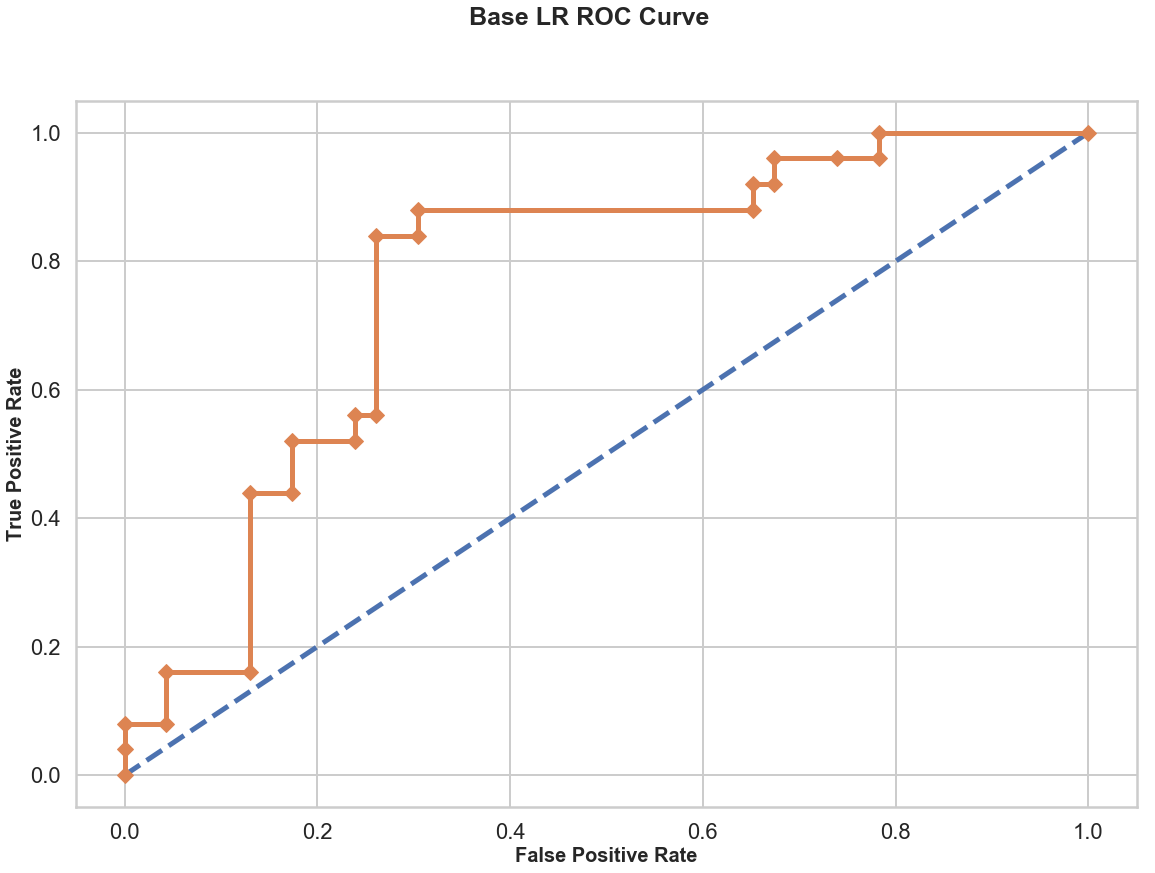

In [29]:
sns.set(style="whitegrid")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(19,13))

# Calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test["2_proj_mngmt"].astype(int), predicted_prob[:,1])

plt.suptitle("Base LR ROC Curve", fontsize=25, weight = 'bold')
plt.xlabel('False Positive Rate', fontsize = 20, weight = 'bold')
plt.ylabel('True Positive Rate', fontsize=20, weight = 'bold')

# The blue dotted diagonal line indicates randomness.
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=5)
# The solid orange line indictaes the roc curve for the model
plt.plot(fpr, tpr, marker='D', linewidth=5)

# show the plot
plt.show()



***  

### (5) Classification Report

In [30]:
target_names = ['False', 'True']
print(classification_report(y_test["2_proj_mngmt"].astype(int), y_pred, target_names=target_names))

              precision    recall  f1-score   support

       False       0.76      0.83      0.79        46
        True       0.62      0.52      0.57        25

   micro avg       0.72      0.72      0.72        71
   macro avg       0.69      0.67      0.68        71
weighted avg       0.71      0.72      0.71        71



***  
### From Baseline Classifier: Making predictions for Unlabeled Data

In [31]:
# Now we will find unlabeled rows for '2_proj_mngmt':
unlabeled_rows = monster_df.loc[monster_df['2_proj_mngmt'].isnull()]
unlabeled_rows = unlabeled_rows.dropna(subset=["job_description"])

In [32]:
# Preproccessing
X_unlabeled = unlabeled_rows['job_description']
#y = unlabeled_rows[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']] --> I don't need this.

In [34]:
X_unlabeled = count_vectorizer.transform(X_unlabeled)
X_unlabeled_tf = tfidf_transformer.transform(X_unlabeled)

In [35]:
unlabeled_pred_result = classifier.predict_proba(X_unlabeled_tf)
unlabeled_pred_result #Probability estimates --> Look for the values, where the differece between x and y values are smallest

array([[0.60907304, 0.39092696],
       [0.47984758, 0.52015242],
       [0.54220434, 0.45779566],
       ...,
       [0.65884869, 0.34115131],
       [0.55137931, 0.44862069],
       [0.50368367, 0.49631633]])

In [36]:
unlabeled_rows["prob_false"] = unlabeled_pred_result[:,0]
unlabeled_rows["prob_true"] = unlabeled_pred_result[:,1]
unlabeled_rows["label_prob_diff"] = unlabeled_rows["prob_false"] - unlabeled_rows["prob_true"]
unlabeled_rows[["prob_false", "prob_true", "label_prob_diff"]].sort_values(by="label_prob_diff", ascending=False)
subset = unlabeled_rows[unlabeled_rows["label_prob_diff"].between(0.01, 0.2)] #Use func, between.
subset = subset[["prob_false", "prob_true", "label_prob_diff", "uniq_id" ]].sort_values(by="label_prob_diff", ascending=True)

,prob_false,prob_true,label_prob_diff,uniq_id
12326,0.505001,0.494999,0.010003,93a37b2d95e2da6120520d4293115c4d
5676,0.505026,0.494974,0.010053,166f060a0140cab6c1d103dbd7359d0d
15578,0.505036,0.494964,0.010071,66bfbec64d310ac0a69df1f72fa7050a
8163,0.505074,0.494926,0.010149,40e3dcacf41fe6a853a4b4ab629858f8
10416,0.505075,0.494925,0.010149,1fc12a1647f39dd7cd58e70b566b7c23
10105,0.505111,0.494889,0.010221,072414657facd7ccac1dc721f4f276bf
13482,0.505141,0.494859,0.010282,9cd87a4be5b9902922e2bc6d49c68e7b
1585,0.505151,0.494849,0.010301,ead3ffd9a6f58adc57ea6d5650dadab2
3697,0.505181,0.494819,0.010362,bb79c3e4c05be386ec72b2cdac01333d
11054,0.505232,0.494768,0.010464,9edd9f3d65c62c7346cde5fec8a4e616


***  

# 5. (1) Building Pipeline: Improve classification: LR with LDA


In [37]:
X_labeled_text = labeled_rows['job_description'] #Text job descriptions
y_labeled = labeled_rows[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']]

In [38]:
X_all = monster_df["job_description"].dropna()

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

# Define Search Param
search_params = {'n_components': [40, 45, 50], 'learning_decay': [0.7, 0.8, 0.9], 
                 'C': [0.85, 1.0]}

# For best_or_model, consider C=, 
# count_vectorizer_lda to be added to the search_params -(e.g.) min_df=100, max_df=0.7
grid = ParameterGrid(search_params)

#These are for lda model:
#Use BoW, not tfidf because BoW is the assumption that lda uses
count_vectorizer_lda = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=100, max_df=0.7)
X_bow = count_vectorizer_lda.fit_transform(X_all) # X_all = monster_df["job_description"].dropna()

for params in grid:
    best_lda_model = LatentDirichletAllocation(n_components=search_params['n_components'], 
                                               learning_decay=search_params['learning_decay'], 
                                               max_iter=100, batch_size=128, evaluate_every=5, n_jobs=-1)
    best_lda_model.fit(X_bow) # Fits the model on the entire dataset
    X_labeled = count_vectorizer_lda.transform(X_labeled_text) 
    # Take the above fitted data to take to the LR model.  To do so, first apply count_vectorizer and apply LDA model.
    X_labeled = best_lda_model.transform(X_labeled) 

    X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.33, random_state=42)
    # y_test['2_proj_mngmt']

    best_lr_model = LogisticRegression(penalty='l2', solver='lbfgs', C=params['C'], class_weight='balanced')
    best_lr_model.fit(X_train, y_train["2_proj_mngmt"].astype(bool))
    y_pred = best_lr_model.predict(X_test) #Predict class labels for samples in X

    #cv_scores = cross_val_score(best_lr_model, X_test, y_pred, cv=2)
    
    cross_entropy = log_loss(y_test["2_proj_mngmt"].astype(bool), y_pred, eps=1e-15)
    
    predicted_prob_2 = best_lr_model.predict_proba(X_test)
    rocauc_score = roc_auc_score(y_test["2_proj_mngmt"].astype(bool), predicted_prob_2[:,1])
    accuracy_score = best_lr_model.score(X_test, y_test["2_proj_mngmt"].astype(bool))
    
    weighted_f1_score = f1_score(y_test["2_proj_mngmt"].astype(bool), y_pred, average='weighted')  
    macro_f1_score = f1_score(y_test["2_proj_mngmt"].astype(bool), y_pred, average='macro')  
    micro_f1_score = f1_score(y_test["2_proj_mngmt"].astype(bool), y_pred, average='micro')
    
    print("Parameters: ", params,",", "\n"
          "Accuracy Score: ", accuracy_score,",", "\n"
          'F1 Weighted: ', weighted_f1_score, ",", "\n"
          'F1 Macro: ', macro_f1_score,",", "\n" 
          'F1 Micro: ', micro_f1_score, ",", "\n"
          'Log Loss: ', cross_entropy, ",", "\n"
          "ROC AUC: ", rocauc_score, "\n\n")
    

In [40]:
# Using the best parameters: 

#These are for lda model:
#Use BoW, not tfidf because BoW is the assumption that lda uses
count_vectorizer_lda = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=100, max_df=0.7)
X_bow = count_vectorizer_lda.fit_transform(X_all) # X_all = monster_df["job_description"].dropna()

best_lda_model = LatentDirichletAllocation(n_components=45, 
                                           learning_decay=0.7, 
                                           max_iter=100, batch_size=128, evaluate_every=5, n_jobs=-1)
best_lda_model.fit(X_bow) # Fits the model on the entire dataset
X_labeled = count_vectorizer_lda.transform(X_labeled_text) 
# Take the above fitted data to take to the LR model.  To do so, first apply count_vectorizer and apply LDA model.
X_labeled = best_lda_model.transform(X_labeled) 

X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.33, random_state=42)
# y_test['2_proj_mngmt']

best_lr_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, class_weight='balanced')
best_lr_model.fit(X_train, y_train["2_proj_mngmt"].astype(bool))
y_pred = best_lr_model.predict(X_test) #Predict class labels for samples in X


predicted_prob_2 = best_lr_model.predict_proba(X_test)
rocauc_score = roc_auc_score(y_test["2_proj_mngmt"].astype(bool), predicted_prob_2[:,1])

In [ ]:
sns.set(style="whitegrid")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(19,13))

# Calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test["2_proj_mngmt"].astype(int), predicted_prob[:,1])

plt.suptitle("Base LR ROC Curve", fontsize=25, weight = 'bold')
plt.xlabel('False Positive Rate', fontsize = 20, weight = 'bold')
plt.ylabel('True Positive Rate', fontsize=20, weight = 'bold')

# The blue dotted diagonal line indicates randomness.
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=5)
# The solid orange line indictaes the roc curve for the model
plt.plot(fpr, tpr, marker='D', linewidth=5)

# show the plot
plt.show()


***  
# 5. (2) Applying the best LDA parameters and display topics

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

X_all = monster_df["job_description"].dropna()

# This produces a feature matrix of token counts, similar to what
# CountVectorizer would produce on text.
count_vectorizer_lda = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=100, max_df=0.7)
# LDA is unsupervised, which means no label required.  

X_bow = count_vectorizer_lda.fit_transform(X_all) # X came from X = labeled_rows['job_description']
# X_tfidf = tfidf_transformer.fit_transform(X_bow)

X_bow_feature_names = count_vectorizer_lda.get_feature_names()

lda = LatentDirichletAllocation(n_components=45, learning_decay=0.7, max_iter=100, batch_size=128, evaluate_every=5, n_jobs=-1)
# # doc_topic_prior=0.05, topic_word_prior=0.05
# # doc_topic_prior --> Alpha, prior of document topic distribution theta. If the value is None, defaults to 1 / n_components.
# # topic_word_prior --> Eta, prior of topic word distribution beta. If the value is None, defaults to 1 / n_components. 

lda.fit(X_bow) 
# # get topics for some given samples:
# lda.transform(X_bow[-2:]) # Picks two examples to show as print for the last two examples
# # (e.g.) array([[0.76497249, 0.00096665, 0.16679877, 0.06627602, 0.00098606],
# #        [0.3278557 , 0.01228623, 0.00148471, 0.13557174, 0.52280162]])
# # The above is the topic weights --> The higher the weight, the higher association of given topic given a doc
# # These topic weights is applied to the Log Reg model we already have.

# print(lda)  # Model attributes

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 15
#display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, X_bow_feature_names, num_top_words)

In [ ]:
print(X_all[12228:12230])

In [ ]:

#These are for lda model:
#Use BoW, not tfidf because BoW is the assumption that lda uses
count_vectorizer_lda = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=100, max_df=0.7)
X_bow = count_vectorizer_lda.fit_transform(X_all) # X_all = monster_df["job_description"].dropna()


best_lda_model = LatentDirichletAllocation(n_components=45, 
                                           learning_decay=0.7, 
                                           max_iter=100, batch_size=128, evaluate_every=5, n_jobs=-1)
best_lda_model.fit(X_bow) # Fits the model on the entire dataset
X_labeled = count_vectorizer_lda.transform(X_labeled_text) 
# Take the above fitted data to take to the LR model.  To do so, first apply count_vectorizer and apply LDA model.
X_labeled = best_lda_model.transform(X_labeled) 

X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.33, random_state=42)
# y_test['2_proj_mngmt']

best_lr_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, class_weight='balanced')
best_lr_model.fit(X_train, y_train["2_proj_mngmt"].astype(bool))
y_pred = best_lr_model.predict(X_test) #Predict class labels for samples in X
y_pred


In [ ]:
best_lr_model.predict_proba(X_test)

In [138]:
t_label = y_test['2_proj_mngmt']

In [ ]:
# print the first 25 true and predicted responses
print('True:', y_test['2_proj_mngmt'].values)
print('False:', y_pred)

In [ ]:
y_test['2_proj_mngmt'].values

In [ ]:
results_df = pd.DataFrame({'y_test':t_label,'y_pred':y_pred})
results_df

***  
# 5. (2) Applying the best LDA parameters and display topics

In [36]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

X_all = monster_df["job_description"].dropna()

count_vectorizer_lda = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=100, max_df=0.7)

X_bow = count_vectorizer_lda.fit_transform(X_all) # X came from X = labeled_rows['job_description']

X_bow_feature_names = count_vectorizer_lda.get_feature_names()

lda = LatentDirichletAllocation(n_components=45, learning_decay=0.7, max_iter=100, batch_size=128, evaluate_every=5, n_jobs=-1)

lda.fit(X_bow) 

print(lda)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=100,
             mean_change_tol=0.001, n_components=45, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)


In [37]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10
#display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, X_bow_feature_names, num_top_words)

Topic 0:
aflac ll one help people business insurance receive team cancer
Topic 1:
must able customers including required job servicemaster equipment knowledge service
Topic 2:
href attr break case test rt mns nonjob com linkedin
Topic 3:
shift production must warehouse job able machine hours shipping inventory
Topic 4:
status employment disability protected veteran race national color origin religion
Topic 5:
project construction projects engineering design manager commercial management job site
Topic 6:
security apply whelan requirements team must background least following education
Topic 7:
retail sales store customer time team customers skills ability job
Topic 8:
business solutions client services team clients management global ability technology
Topic 9:
job data want centurylink network services family new qualifications customer
Topic 10:
store manager assistant ability associates tasks customer position service inventory
Topic 11:
aflac insurance company fortune benefits one b

***  

# 6. Possible Interview Questions for 2_self_mngmt

In [83]:
interview_q_df = pd.read_excel("/Users/yukolopez/Desktop/SI630/Assignments/FinalProject/LR+LDA/behavioral_interview_q.xlsx", 
                 error_bad_lines=False, sheet_name="Sheet1", na_filter=False, encoding= 'utf-8')

In [84]:
interview_q_df = interview_q_df.replace({'T':True, 'F':False, '':np.nan})

In [85]:
interview_q_df['class_2'].unique()

array([True, False], dtype=object)

In [88]:
# q = []
# for each in interview_q_df['class_2'].unique(): 
qs = interview_q_df.loc[interview_q_df['class_2'] == True][["q_id", "interview_q"]]


for index, b in qs.iterrows():
    print(b["q_id"], b["interview_q"])


1 Tell me a little bit about yourself.
2 What do you know about our company and/or industry? What do you know about our competitors?
3 Why do you want to work here?
4 Why should we hire YOU? What can you do for us that someone else cannot?
5 In what ways do you think you can make a contribution to our company? What makes you qualified for this position?
6 What would you do, or hope to accomplish in your first 90 days on the job?
7 Why did you leave your last job?   or Why do you want to leave your current employer?
8 Why have you had so many jobs in such a short period of time?
9 Have you ever been fired or forced to resign?
10 Describe a situation in which you found that your results were not up to your supervisor's expectations.  What happened?  What action did you take?
11 Describe some times when you were not very satisfied or pleased with your own performance, even though nobody else knew about it.  What did you do about it?
12 Talk about some situations where you had to adjust qu

***  

## ROC Curve Plot for All Classes

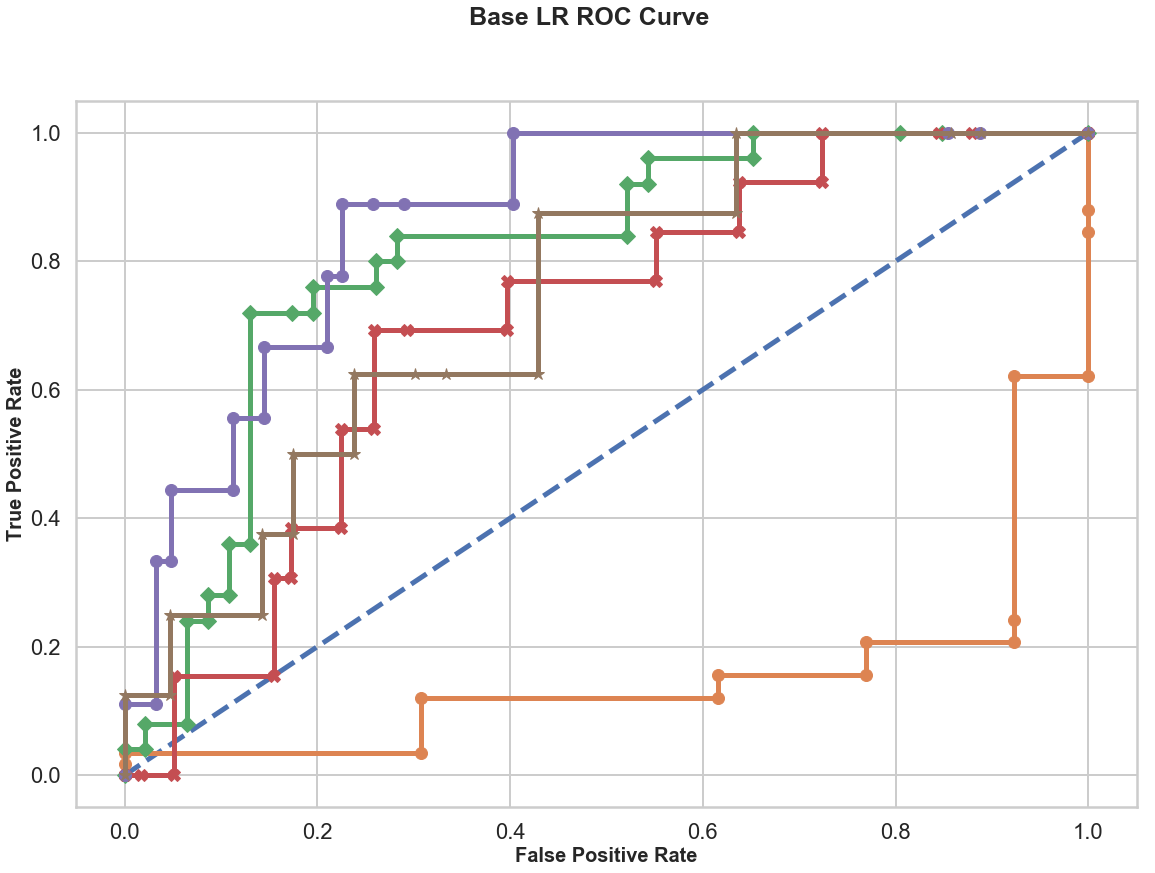

In [137]:
sns.set(style="whitegrid")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(19,13))

predicted_prob = best_lr_model.predict_proba(X_test)

# Calculate roc curve
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test["1_self_mngmt"].astype(int), predicted_prob_1[:,1])
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test["2_proj_mngmt"].astype(int), predicted_prob[:,1])
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test["3_ppl_mngmt"].astype(int), predicted_prob[:,1])
fpr_4, tpr_4, thresholds_4 = roc_curve(y_test["4_prog_mngmt"].astype(int), predicted_prob[:,1])
fpr_5, tpr_5, thresholds_5 = roc_curve(y_test["5_org_mngmt"].astype(int), predicted_prob[:,1])


plt.suptitle("Base LR ROC Curve", fontsize=25, weight = 'bold')
plt.xlabel('False Positive Rate', fontsize = 20, weight = 'bold')
plt.ylabel('True Positive Rate', fontsize=20, weight = 'bold')

# The blue dotted diagonal line indicates randomness.
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=5)
# The solid orange line indictaes the roc curve for the model

plt.plot(fpr_1, tpr_1, marker='o', linewidth=5)
plt.plot(fpr_2, tpr_2, marker='D', linewidth=5)
plt.plot(fpr_3, tpr_3, marker='X', linewidth=5)
plt.plot(fpr_4, tpr_4, marker='o', linewidth=5)
plt.plot(fpr_5, tpr_5, marker='*', linewidth=5)

# show the plot
plt.show()

